In [1]:
from devito import *
from examples.seismic.source import WaveletSource
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (81, 81)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

Allocating memory for src ((170, 1))
Allocating memory for src_coords ((1, 2))


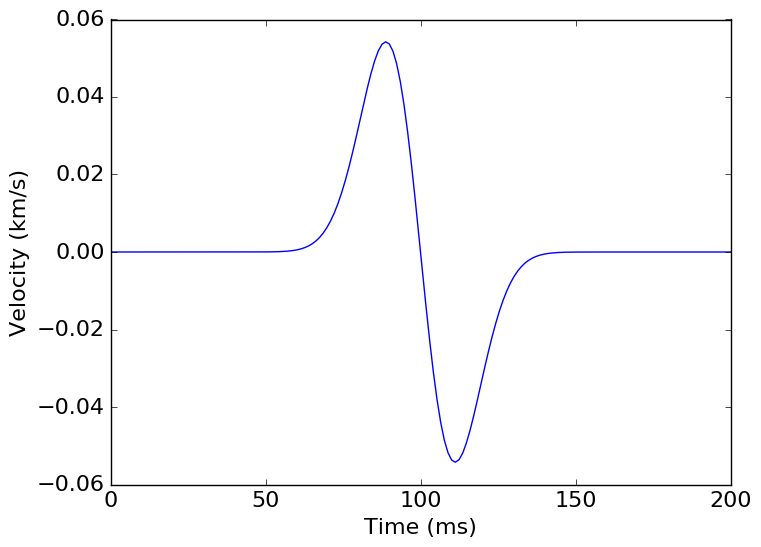

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1./f0) * np.exp(-a * (t - 1./f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 200.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

src = DGaussSource(name='src', grid=grid, f0=0.01, time=time)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
# Now we create the velocity and pressure fields
p = TimeFunction(name='p', grid=grid)
vx= TimeFunction(name='vx', grid=grid, staggered=(0, 1, 0))
vz = TimeFunction(name='vz', grid=grid, staggered=(0, 0, 1))

P = p.indexed
VX = vx.indexed
VZ = vz.indexed

In [5]:
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
#V_s = 1.0
density = 3.

dx = 100.
rox = 1/density * dt/x.spacing
roz = 1/density * dt/z.spacing
l2m = V_p*V_p*density * dt/x.spacing

c1 = 9.0/8.0;
c2 = -1.0/24.0;

# The source injection term
src_p = src.inject(field=p, expr=src)


### 2nd order acoustic according to fdelmoc
###########################################
#vx[ix*n1+iz] -= rox[ix*n1+iz]*(p[ix*n1+iz] - p[(ix-1)*n1+iz]);
u_vx_2 = Eq(vx.forward, vx + rox * (-P[t, x, z] + P[t, x-1, z]))
          
#vz[ix*n1+iz] -= roz[ix*n1+iz]*(p[ix*n1+iz] - p[ix*n1+iz-1]);
u_vz_2 = Eq(vz.forward, vz + roz * (-P[t, x, z] + P[t, x, z-1]))

#p[ix*n1+iz] -= l2m[ix*n1+iz]*( (vx[(ix+1)*n1+iz] - vx[ix*n1+iz]) + (vz[ix*n1+iz+1]   - vz[ix*n1+iz]));
u_p_2 = Eq(p.forward, p + l2m * ( (-VX[t+1, x+1, z] + VX[t+1, x, z]) + (-VZ[t+1, x, z+1] + VZ[t+1, x, z])))

op_2 = Operator(src_p + [u_vx_2, u_vz_2, u_p_2], dse=None, dle=None)


### 4th order acoustic according to fdelmoc
###########################################
#vx[ix*n1+iz] -= rox[ix*n1+iz]*(c1*(p[ix*n1+iz] - p[(ix-1)*n1+iz]) + c2*(p[(ix+1)*n1+iz] - p[(ix-2)*n1+iz]));
u_vx_4 = Eq(vx.forward, vx - rox * (c1*(P[t, x, z] - P[t, x-1, z]) + c2*(P[t, x+1, z] - P[t, x-2, z])))

#vz[ix*n1+iz] -= roz[ix*n1+iz]*(c1*(p[ix*n1+iz]- p[ix*n1+iz-1]) + c2*(p[ix*n1+iz+1] - p[ix*n1+iz-2]));
u_vz_4 = Eq(vz.forward, vz - roz * (c1*(P[t, x, z] - P[t, x, z-1]) + c2*(P[t, x, z+1] - P[t, x, z-2])))

#p[ix*n1+iz] -= l2m[ix*n1+iz]*(c1*(vx[(ix+1)*n1+iz] - vx[ix*n1+iz]) + c2*(vx[(ix+2)*n1+iz] - vx[(ix-1)*n1+iz])
#                            + c1*(vz[ix*n1+iz+1] - vz[ix*n1+iz]) + c2*(vz[ix*n1+iz+2] - vz[ix*n1+iz-1]));
u_p_4 = Eq(p.forward, p - l2m * (c1*(VX[t+1, x+1, z] - VX[t+1, x, z]) + c2*(VX[t+1, x+2, z] - VX[t+1, x-1, z])
                               + c1*(VZ[t+1, x, z+1] - VZ[t+1, x, z]) + c2*(VZ[t+1, x, z+2] - VZ[t+1, x, z-1])))

op_4 = Operator(src_p + [u_vx_4, u_vz_4, u_p_4], dse=None, dle=None)
#print(op_4.ccode)

In [6]:
# The end values are fucking ridiculous...!
# Apparently the argument engine always ADDS stencil offsets, even to the end vars!
args = {'t': nt, 'time': nt, 'x_s': 2, 'x_e': shape[0]-8, 'z_s': 2, 'z_e':shape[1]-8}
#print(args)
#print(op.arguments(**args))

Allocating memory for vx ((2, 80, 81))
Allocating memory for vz ((2, 81, 80))
Allocating memory for p ((2, 81, 81))
GNUCompilerNoAVX: compiled /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-ViJbTO/52b81f5b6f45aa94f5eef752f95b32f7f04075e0.c [0.25 s]
Section section_0<170,1> with OI=2.78 computed in 0.000 s [1.36 GFlops/s]
Section main<170,71,71> with OI=0.55 computed in 0.010 s [1.18 GFlops/s, 0.08 GPts/s]


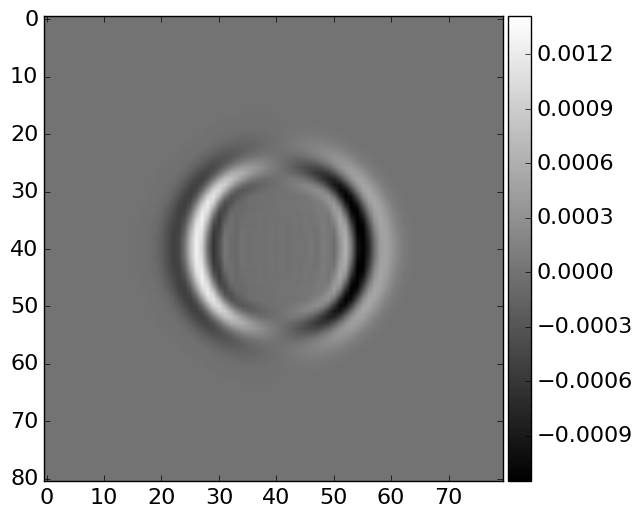

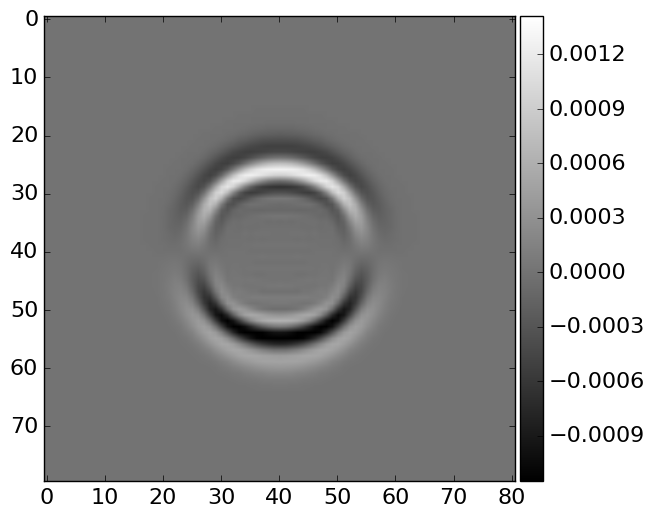

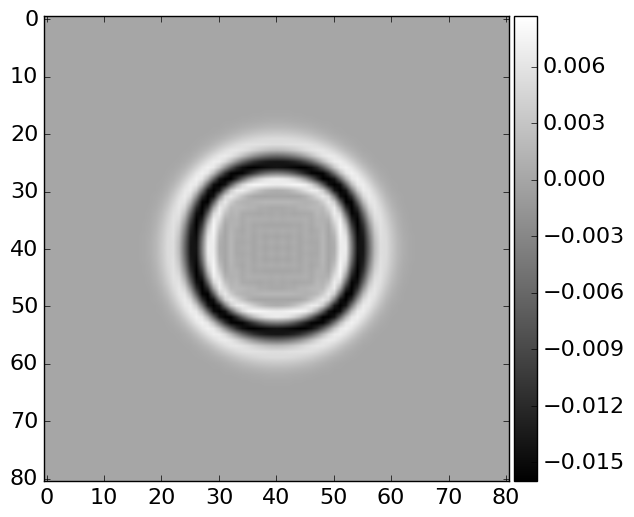

In [7]:
### 2nd order acoustic

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
p.data[:] = 0.


op_2(**args)

# Let's see what we got....
plot_image(vx.data[0])
plot_image(vz.data[0])
plot_image(p.data[0])

GNUCompilerNoAVX: compiled /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-ViJbTO/e9bbd4b4874c86a2a0a3c79d14115e12e854676b.c [0.34 s]
Section section_0<170,1> with OI=2.78 computed in 0.000 s [1.12 GFlops/s]
Section main<170,71,71> with OI=1.41 computed in 0.034 s [0.96 GFlops/s, 0.03 GPts/s]


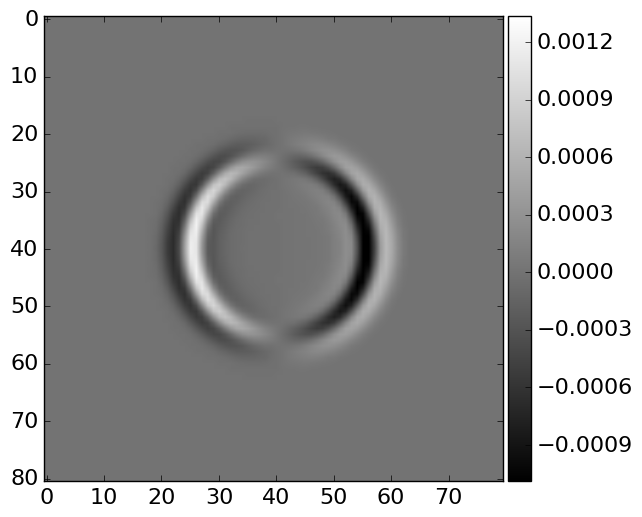

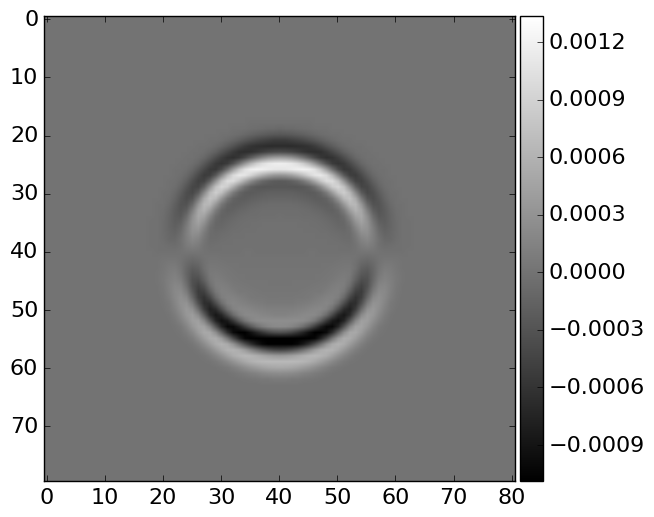

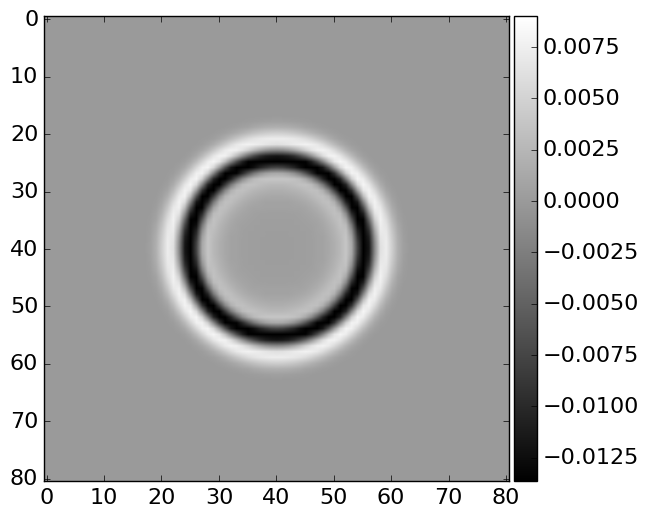

In [8]:
### 4th order acoustic

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
p.data[:] = 0.

op_4(**args)

# Let's see what we got....
plot_image(vx.data[0])
plot_image(vz.data[0])
plot_image(p.data[0])